In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
import csv
import itertools

Setup image size, architecture, batch size (standard parameters)

In [5]:
_IMAGE_SIZE = 224
_MODEL_ARCHITECTURE = resnet34
_BATCH_SIZE = 24 # Batch size

In [6]:
_DATA_PATH = os.path.join(os.path.expanduser('~'), 'data', 'plantseedlings')

The data for this competition came in the form of a training set and a test set of folders with labelled images. We'll want to hold back some of our images as a validation set.

In order to do that, lets go over each image in each labelled folder and generate a CSV file with filename/label pairs.

Note that FastAI assumes that the CSV file will always have two columns, even if data has multiple labels. It then splits the labels into multiple labels by splitting on whitespace.

In [16]:
def handle_whitespace(category):
    return category.replace(' ', '_')

# ImageDataClassifier hand-implements CSV parsing in a very strange
# way and does not like spaces in filenames
def generate_csv_labels(training_folder):
    return itertools.chain.from_iterable([
        [
            (os.path.join(training_folder, dirname, item), category)
            for item in os.listdir(os.path.join(training_folder, dirname))
        ] for category, dirname in [
            (handle_whitespace(c), c) for c in os.listdir(training_folder)
        ]
    ])
_ALL_CSV_LABELS = list(generate_csv_labels(os.path.join(_DATA_PATH, 'train')))

In [17]:
_VALIDATION_INDICES = get_cv_idxs(len(_ALL_CSV_LABELS) - 1)

Write out the labels, which we'll use later

In [18]:
with open(os.path.join(_DATA_PATH, 'labels.csv'), 'w') as csv_labels:
    w = csv.writer(csv_labels)
    for label_pair in _ALL_CSV_LABELS:
        w.writerow(label_pair)

In [19]:
transformations = tfms_from_model(_MODEL_ARCHITECTURE,
                                  _IMAGE_SIZE,
                                  aug_tfms=transforms_side_on,
                                  max_zoom=1.1)
training_data = ImageClassifierData.from_csv(_DATA_PATH,
                                             'train',
                                             os.path.join(_DATA_PATH,
                                                          'labels.csv'),
                                             test_name='test',
                                             val_idxs=_VALIDATION_INDICES,
                                             bs=_BATCH_SIZE,
                                             tfms=transformations)

Pretrained learner to figure out a good learning rate

In [20]:
learner = ConvLearner.pretrained(_MODEL_ARCHITECTURE,
                                 training_data,
                                 precompute=True,
                                 ps=0.5)

In [21]:
learner.lr_find()

 72%|███████▏  | 114/159 [00:01<00:00, 92.07it/s, loss=9.41]


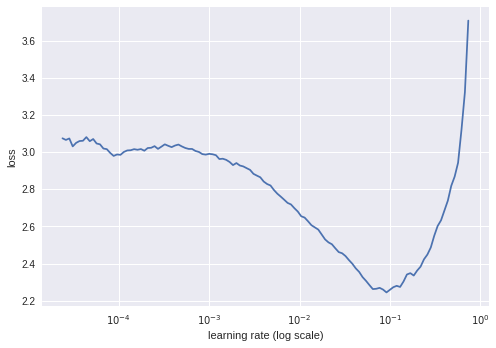

In [22]:
learner.sched.plot()

Fit the dense layers

In [24]:
# A learning rate of 0.03 seems to make sense here
learner.precompute = False
learner.fit(0.03, 5, cycle_len=1, cycle_mult=1)


 23%|██▎       | 36/159 [00:07<00:25,  4.88it/s, loss=0.96]

 23%|██▎       | 37/159 [00:07<00:24,  4.91it/s, loss=0.968]

Exception in thread Thread-13:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




 99%|█████████▉| 158/159 [00:28<00:00,  5.53it/s, loss=0.967]
                                                             [ 0.       0.9666   0.58987  0.78798]

 99%|█████████▉| 158/159 [00:28<00:00,  5.52it/s, loss=0.942]
                                                             [ 1.       0.94188  0.5902   0.78902]

 99%|█████████▉| 158/159 [00:28<00:00,  5.59it/s, loss=0.904]
                                                             [ 2.       0.90365  0.54859  0.80361]

 99%|█████████▉| 158/159 [00:28<00:00,  5.49it/s, loss=0.818]
                                                             [ 3.       0.8178   0.54274  0.82027]

 99%|█████████▉| 158/159 [00:28<00:00,  5.53it/s, loss=0.795]
                                                             [ 4.       0.79486  0.51994  0.82115]



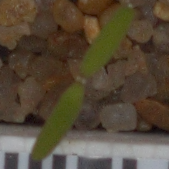

In [31]:
# Lets have a look at one of the images to see how different it is from
# what ImageNet would have been
PIL.Image.open(os.path.join(_DATA_PATH, 'train', 'Fat Hen', '22cd06b64.png'))

Use differential learning rates to train the convolutional layers

In [34]:
learner.unfreeze()
learner.precompute = False
learner.fit([0.03 * 0.001, 0.03 * 0.01, 0.03], 5, cycle_len=1, cycle_mult=1)



  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/159 [00:01<?, ?it/s, loss=2.21]

  1%|          | 1/159 [00:01<03:32,  1.34s/it, loss=2.21]

  1%|          | 1/159 [00:01<04:41,  1.78s/it, loss=2.03]

  1%|▏         | 2/159 [00:01<02:20,  1.12it/s, loss=2.03]

  1%|▏         | 2/159 [00:02<02:54,  1.11s/it, loss=1.76]

  2%|▏         | 3/159 [00:02<01:56,  1.34it/s, loss=1.76]

  2%|▏         | 3/159 [00:02<02:18,  1.13it/s, loss=1.65]

  3%|▎         | 4/159 [00:02<01:43,  1.49it/s, loss=1.65]

  3%|▎         | 4/159 [00:03<02:00,  1.29it/s, loss=1.63]

  3%|▎         | 5/159 [00:03<01:35,  1.60it/s, loss=1.63]

  3%|▎         | 5/159 [00:03<01:49,  1.41it/s, loss=1.65]

  4%|▍         | 6/159 [00:03<01:30,  1.68it/s, loss=1.65]

  4%|▍         | 6/159 [00:03<01:41,  1.51it/s, loss=1.65]

  4%|▍         | 7/159 [00:03<01:26,  1.75it/s, loss=1.65]

  4%|▍         | 7/159 [00:04<01:35,  1.59it/s, loss=1.7] 

  5%|▌         | 8/159 [00:04<01:23,  1.81it/s, loss=1.7]

  5%|▌

In [35]:
log_predictions, y = learner.TTA()
probabilities = np.exp(log_predictions)



  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:07<00:22,  7.54s/it]

 50%|█████     | 2/4 [00:15<00:15,  7.56s/it]

 75%|███████▌  | 3/4 [00:22<00:07,  7.58s/it]

100%|██████████| 4/4 [00:30<00:00,  7.63s/it]

                                             

In [37]:
accuracy(log_predictions, y), metrics.log_loss(y, probabilities)

(0.93045310853530028, 0.19365296017965697)

In [49]:
log_predictions = learner.predict(is_test=True)

In [61]:
csv_data = [(os.path.basename(training_data.test_ds.fnames[index]), training_data.classes[classification])
 for index, classification in enumerate(np.argmax(np.exp(log_predictions), axis=1))]

Checking a few different image types to see if we predicted correctly

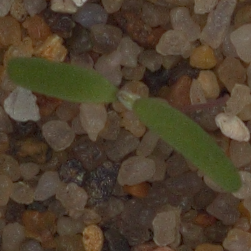

In [55]:
PIL.Image.open(os.path.join(_DATA_PATH, 'test', 'f9ea23fb5.png'))

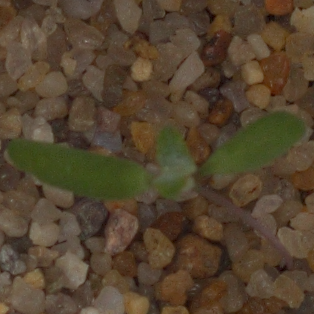

In [56]:
PIL.Image.open(os.path.join(_DATA_PATH, 'test', '1c52ea820.png'))

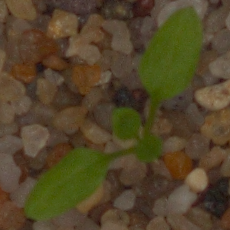

In [57]:
PIL.Image.open(os.path.join(_DATA_PATH, 'test', '780defa2e.png'))

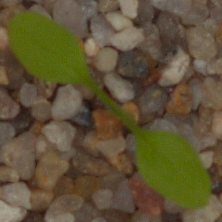

In [58]:
PIL.Image.open(os.path.join(_DATA_PATH, 'test', 'a55d26a4c.png'))

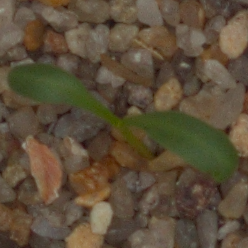

In [60]:
PIL.Image.open(os.path.join(_DATA_PATH, 'test', 'bfab3e3d0.png'))

Store submission, re-adding whitespace

In [64]:
with open('submission.csv', 'w') as submission_csv_fileobj:
    writer = csv.writer(submission_csv_fileobj)
    writer.writerow(['file', 'species'])
    for filename, label in csv_data:
        writer.writerow([filename, label.replace('_', ' ')])